In [21]:
from matplotlib import pyplot as plt
from termcolor import colored
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import cartopy
import matplotlib.gridspec as gridspec
from glob import iglob
from os.path import join
from functools import reduce
import pandas as pd
import harp
import itertools
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as patches
from netCDF4 import Dataset

In [6]:
#Look for NO2 in target folder
product_path = "F:\mar2020"
input_files_offl= sorted(list(iglob(join(product_path,'**', '*L2*.nc4'),recursive=True)))
#input_files_nrt= sorted(list(iglob(join(product_path,'**', '*2021*.nc'),recursive=True)))
print(colored('NO2 OFFL products detected:','green'), len(input_files_offl))
#print(colored('NO2 NRTI products detected:','green'), len(input_files_nrt))
s5p_file=input_files_offl[0]


NO2 OFFL products detected: 44


In [7]:
#Open product - Global attributes 
with xr.open_dataset(s5p_file) as s5p_img_GA:
    print(colored('Global attribute of product:\n','blue'),s5p_img_GA)

#Product Metadata
with xr.open_dataset(s5p_file, group='METADATA/GRANULE_DESCRIPTION') as s5p_img_MT:
    print(colored('\nMETADATA/GRANULE_DESCRIPTION Grpup:\n','blue'), s5p_img_MT)
with xr.open_dataset(s5p_file, group='PRODUCT') as s5p_img_PRD:
    print(colored('\nProduct Group:\n','blue'), s5p_img_PRD)


Global attribute of product:
 <xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    Conventions:                        CF-1.7
    institution:                        KNMI
    source:                             Sentinel 5 precursor, TROPOMI, space-...
    summary:                            TROPOMI/S5P NO2 1-Orbit L2 Swath 7x3.5km
    tracking_id:                        73f4e17d-1b1e-4d07-b326-628f5e81b25b
    id:                                 S5P_OFFL_L2__NO2____20210501T055534_2...
    time_reference:                     2021-05-01T00:00:00Z
    time_reference_days_since_1950:     26053
    time_reference_julian_day:          2459335.5
    time_reference_seconds_since_1970:  1619827200
    time_coverage_start:                2021-05-01T06:17:08Z
    time_coverage_end:                  2021-05-01T07:15:32Z
    time_coverage_duration:             PT3504.399S
    time_coverage_resolution:           PT0.840S
    orbit:                              18385
    refe

In [8]:
#Extract key for using later
date = s5p_img_GA.attrs['time_reference'][:s5p_img_GA.attrs['time_reference'].find('T')]
date

'2021-05-01'

In [9]:
"""
Multi Temporal Analysis
"""

#Export Path
export_path = 'F:\mar2020'

# Calling Harp and creating L3 product
harp_op= '\
    tropospheric_NO2_column_number_density_validity>75;\
    latitude > 20.0 [degree_north]; latitude < 27.0 [degree_north];\
    derive(tropospheric_NO2_column_number_density[Pmolec/cm2]);\
    bin_spatial(700,20.0, 0.01, 600, 87.0, 0.01 );\
    derive(datetime_stop{time});\
    derive(latitude{latitude}); derive(longitude{longitude});\
    keep(NO2_column_number_density, tropospheric_NO2_column_number_density, NO2_slant_column_number_density,latitude_bounds, longitude_bounds, latitude, longitude )'

for i in input_files_offl:
    print(i)
    harp_L2_L3 = harp.import_product(i, operations=harp_op)
    export_filename = "{name}".format(name=i.replace('L2','L3'))
    harp.export_product(harp_L2_L3, export_filename, file_format='netcdf')

    

print(colored('All L2 products converted to L3','green'))

F:\mar2020\S5P_OFFL_L2__NO2____20210501T055534_20210501T073705_18385_01_010400_20210502T232330.SUB.nc4
F:\mar2020\S5P_OFFL_L2__NO2____20210502T053637_20210502T071808_18399_01_010400_20210503T224404.SUB.nc4
F:\mar2020\S5P_OFFL_L2__NO2____20210502T071808_20210502T085938_18400_01_010400_20210504T002008.SUB.nc4
F:\mar2020\S5P_OFFL_L2__NO2____20210503T065911_20210503T084041_18414_01_010400_20210505T001700.SUB.nc4
F:\mar2020\S5P_OFFL_L2__NO2____20210505T062116_20210505T080246_18442_01_010400_20210506T232857.SUB.nc4
F:\mar2020\S5P_OFFL_L2__NO2____20210506T060219_20210506T074349_18456_01_010400_20210507T231458.SUB.nc4
F:\mar2020\S5P_OFFL_L2__NO2____20210507T054321_20210507T072451_18470_01_010400_20210508T231817.SUB.nc4
F:\mar2020\S5P_OFFL_L2__NO2____20210507T072451_20210507T090622_18471_01_010400_20210509T005411.SUB.nc4
F:\mar2020\S5P_OFFL_L2__NO2____20210508T052424_20210508T070554_18484_01_010400_20210509T224341.SUB.nc4
F:\mar2020\S5P_OFFL_L2__NO2____20210508T070554_20210508T084724_18485_01_0

In [3]:
attributes = {
    i.split('/')[-1]:{
        'time_coverage_start': xr.open_dataset(i).attrs
    } for i in input_files_offl
}

#Print only first items in dictionary as example
#dict(itertools.islice(attributes.items(),1))

In [4]:
#Export Path
export_path = 'F:\mar2020'

#create list of L3 products
filename_L3 = sorted(list(iglob(join(product_path, '**', '*L3*.nc4'), recursive=True)))
print(colored('L3 NO2 OFFL products detected:','green'), len(filename_L3))


L3 NO2 OFFL products detected: 39


In [9]:
#Create a time coordinate with np datatype datetime64 Important to allow index later
#Export Path
export_path = 'F:\mar2020'

def preprocess(ds):
        ds['time'] = pd.to_datetime(np.array([date])).values
        return ds

L3_march_20 = xr.open_mfdataset(filename_L3, combine='nested', concat_dim='time', preprocess=preprocess, chunks={'time':100})
L3_march_20

<xarray.Dataset>
Dimensions:                                 (independent_2: 2, latitude: 699, longitude: 599, time: 39)
Coordinates:
  * latitude                                (latitude) float64 20.01 ... 26.98
  * longitude                               (longitude) float64 87.0 ... 92.98
  * time                                    (time) datetime64[ns] 2021-05-01 ...
Dimensions without coordinates: independent_2
Data variables:
    tropospheric_NO2_column_number_density  (time, latitude, longitude) float64 dask.array<chunksize=(1, 699, 599), meta=np.ndarray>
    NO2_column_number_density               (time, latitude, longitude) float64 dask.array<chunksize=(1, 699, 599), meta=np.ndarray>
    NO2_slant_column_number_density         (time, latitude, longitude) float64 dask.array<chunksize=(1, 699, 599), meta=np.ndarray>
    latitude_bounds                         (time, latitude, independent_2) float64 dask.array<chunksize=(1, 699, 2), meta=np.ndarray>
    longitude_bounds                        (time, longitude, independent_2) float64 dask.array<chunksize=(1, 599, 2), meta=np.ndarray>
Attributes:
    Conventions:     HARP-1.0
    source_product:  S5P_OFFL_L2__NO2____20210501T055534_20210501T073705_1838...
    history:         2021-06-11T10:06:47Z [harp-1.11] harp.import_product('F:...

In [10]:
#Resampling
L3_march_20=L3_march_20.resample(time='1D').mean(dim='time', skipna=None)

In [11]:
#Mean Value for march 2020
L3_march_20_mean = L3_march_20.mean(dim='time')
no2_20_mean = L3_march_20_mean['tropospheric_NO2_column_number_density']

print(colored('Dataset for March 2020', 'blue'), no2_20_mean)

Dataset for March 2020 <xarray.DataArray 'tropospheric_NO2_column_number_density' (latitude: 699, longitude: 599)>
dask.array<mean_agg-aggregate, shape=(699, 599), dtype=float64, chunksize=(699, 599), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 20.01 20.02 20.02 20.04 ... 26.96 26.98 26.98
  * longitude  (longitude) float64 87.0 87.02 87.03 87.03 ... 92.97 92.97 92.98


In [12]:
#Select month to display
data= no2_20_mean
year = 2020

E:\Anaconda\lib\site-packages\dask\array\numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
E:\Anaconda\lib\site-packages\cartopy\mpl\gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
E:\Anaconda\lib\site-packages\cartopy\mpl\gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(90.5, 23.8, 'Dhaka')

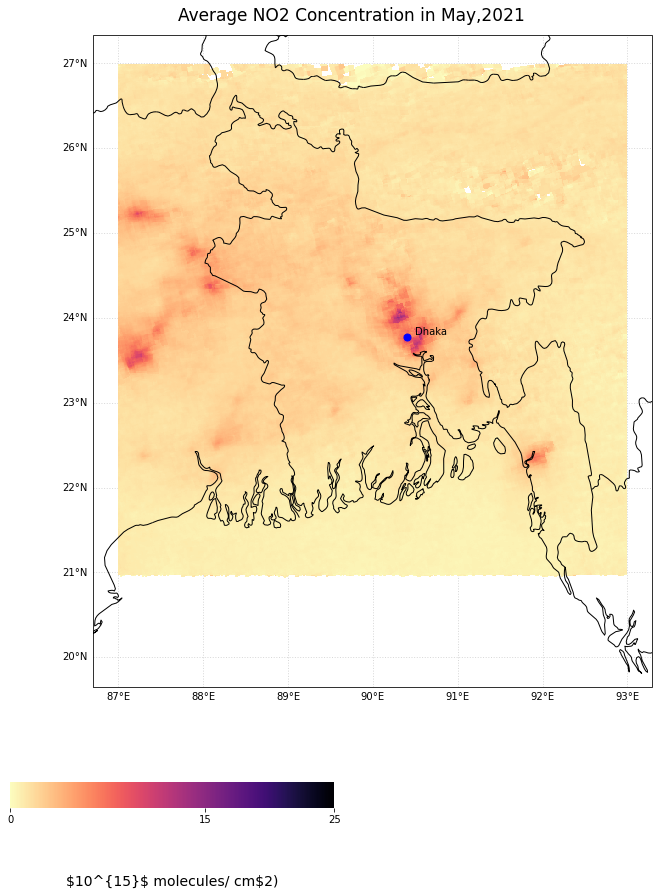

In [16]:
#Image desing
fig = plt.figure(figsize=(18,12))

#Main Map
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
#ax.set_extent([20,26,87,93]) #add the dhaka coordinate

im = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),cmap='magma_r', vmin=0, vmax=25, x='longitude', y='latitude', zorder=3 )
im.colorbar.remove()

#Add Text
ax.text(87.7,27.5, 'Average NO2 Concentration in May,2021', fontsize = 17)

#add countries
#ax.add_feature(states)

ax.coastlines(zorder=3)
ax.add_feature(cartopy.feature.BORDERS.with_scale('10m'), zorder=3)


#set colorbar properties
cbar_ax = fig.add_axes([0.25, -0.015, 0.25, 0.03])
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks=[0,15,25])
cbar.set_label(r'$10^{15}$ molecules/ cm$2)', labelpad=50, fontsize=14)
cbar.outline.set_visible(False)
#cbar.ax.set_yticklabels(['0','1','5','10','15'])


#set plot frame color
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#Add Dhaka to the Map
ax.plot(90.399452,23.777176, 'bo', markersize=7, transform=ccrs.PlateCarree(), zorder=3)
ax.text(90.5 ,23.8, 'Dhaka', transform=ccrs.PlateCarree())
#plt.savefig('export_path\NO2_202004_01_07.jpg')